# CSC421 Assignment 2: Convolutional Networks

**Deadline**: March 5, 2021 by 10pm

**Submission**: Submit a PDF report containing your code, outputs,
and your written solutions.
You may export the completed notebook, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
February 5, 10pm, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.


In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [12]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

We will be releasing the combined assignment 2 data set from the entire
class on Quercus. There will be an announcement with the data set is posted.
You can complete coding Q1 even before the data set is released. In fact,
we recommend testing your code with just your own set of shoes, so the code
runs faster!


There will be three main folders in the file:
`train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets.

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images
from 10 students who submitted images of either exclusively men's shoes or women's shoes.

If you are using Google Colab, upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section (ideally this entire handout)
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 1 pts

Why might we care about the accuracies of the men's and women's shoes as two
separate measures? Why would we expect our model accuracies for the two groups
to be different?

Recall that your application may help people who are visually impaired.

In [ ]:
# The sizes of men and women shoes are of different as women shoes 
# are typically smaller than men's.
# Therefore we must classify them differently when find the accuracies.

### Part (b) -- 4 pts

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training! (why??)**

This function might take a while to run---it might take 3-4 minutes just to load the files from Google Drive.
If you want to avoid running this code multiple times, you can save your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [31]:
import glob
fold_name = ["/content/gdrive/My Drive/CSC413/413data/train/*.jpg", 
             "/content/gdrive/My Drive/CSC413/413data/test_m/*.jpg", 
             "/content/gdrive/My Drive/CSC413/413data/test_w/*.jpg"]
data = []
for name in fold_name:
  shoe = 0
  student = 0
  pair = 0
  side = 0
  index = fold_name.index(name)
  data.append(np.zeros((len(sorted(glob.glob(name)))//6, 3, 2, 224, 224, 3))) # adds a 3x2x244x244x3 empty array at each index
  for file in sorted(glob.glob(name)):
    filename = file.split("/")[-1]              # get the name of the .jpg file
    img = plt.imread(file)                      # read the image as a numpy array
    img = img[:, :, :3]/255 - 0.5               # remove the alpha channel
    data[index][student, pair, side] = img      # adds image to dataset based on folder index
    shoe += 1                                   
    if shoe % 6 == 0:                           # since sorted, every 6th shoe will be the next student
      student += 1
    side = (side + 1) % 2                       
    if side % 2 == 0 :                          
      pair = (pair + 1) % 3

np.random.shuffle(data[0])
train_data = data[0][:89]
valid_data = data[0][89:]
test_data_w = data[1]
test_data_m = data[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


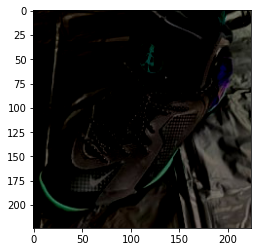

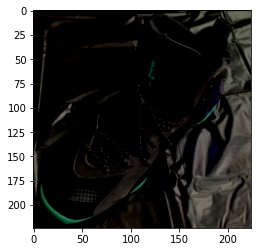

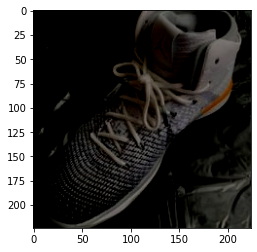

In [32]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (c) -- 2 pts

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take as input an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in part (c).

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

(Later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires)

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


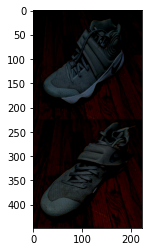

In [33]:
# Your code goes here
def generate_same_pair(data):
  sp1 = np.concatenate((data[:, 0, :1], data[:, 0, 1:]), axis=2)
  sp2 = np.concatenate((data[:, 1, :1], data[:, 1, 1:]), axis=2)
  sp3 = np.concatenate((data[:, 2, :1], data[:, 2, 1:]), axis=2)
  sp = np.concatenate((sp1, sp2))
  sp = np.concatenate((sp, sp3))
  return sp[:,0]

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

### Part (d) -- 2 pts

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each student image submissions, there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


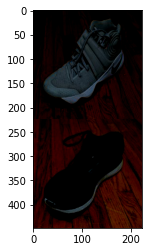

In [34]:
# Your code goes here
def generate_different_pair(data):
  dp1 = np.concatenate((data[:, 0, :1], data[:, 1, 1:]), axis=2)
  dp2 = np.concatenate((data[:, 1, :1], data[:, 2, 1:]), axis=2)
  dp3 = np.concatenate((data[:, 2, :1], data[:, 0, 1:]), axis=2)
  dp = np.concatenate((dp1, dp2))
  dp = np.concatenate((dp, dp3))
  return dp[:,0]
  

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]) # should show 2 shoes from different pairs

### Part (e) -- 1 pts

Why do we insist that the different pairs of shoes still come from the same
student?  (Hint: what else do images from the same student have in common?)

In [ ]:
# This is because the background will be 
# the same and the lighting will be the same.

### Part (f) -- 1 pts

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [ ]:
# Overfitting could occur because we have a surplus of one class
# This will cause the model to predict shoes from not the same pair

## Question 2. 1D Convolutions

In our treatment of convolutional neural networks,
we focused on CNNs for images, which has a 2D geometry.
Other types of data like audio, text, and time series data have a 1D geometry,
and we can use convolutions for those data sets as well.
For audio data, you can think of convolutions
as detecting features in a small region in time.

1D convolutions are simpler numerically, so it is worth
looking at the math and computation behind 1D convolutions
before we analyze 2D convolutions.

Suppose we have audio or time series data that looks like this,
where the target $t$ is binary:

| x | t  |
|------------------------------|-----|
| [1, 2, 3, 1, 0, -1, 3] | 1 |
| [0, 1, 4, 3, 1, 1, 1] | 1 |
| [1, 3, 2, 1, 1, 0, 1] | 0 |

A 1D convolution can be applied by taking a 1D kernel (say [-1, 2, -1]),
and sliding it across the sequence.
At each position, we compute the dot product between the input with the kernel,
like this:

![](1dconv.png){ width=2in }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)

### Part (a) -- 2 pts

Suppose we are building a neural network to classify time series data like the one
above. The architecture we choose will look like this:

- In the first layer, we'll apply a 1D convolution with kernel size 3. The number of
  input channels is 1, and the number of output channels is also 1. We won't use any
  zero padding.
  We'll initialize the weights of this 1D convolution to ${\bf w}^{(1)} = [-1, 2, -1]$
  like in the figure, and initialize the bias to ${\bf b}^{(1)} = 0$.
  We will apply the ReLU activation after this layer.
- In the second layer, we'll have a fully-connected layer. There are 5 input units,
  and a single output unit. We'll initialize all the weights and biase to 1 so 
  $w_k^{(2)} = 1$ and $b^{(2)} = 1$.
- We'll use the cross-entropy loss.

Compute the forward pass for the data point $x = [1, 3, 2, 1, 1, 0, 1]$, $t = 0$

In [ ]:
# [1,3,2,1,1,0,1] with kernel [-1,2,-1], do dot product = [3,0,-1,1,-2]
# Apply ReLU to [3,0,-1,1,-2] = [3,0,0,1,0]
# FC layer = sum([3,0,0,1,0]) with weights and biases = 5

### Part (b) -- 3 pts

Use backpropagation to compute the error signal $\overline{{\bf w}^{(1)}}$ of the
1D convolution kernel for the same single data point $x = [1, 3, 2, 1, 1, 0, 1]$, $t = 0$.
Show your steps.
You do not need to compute the error signal for the other parameters.

In [ ]:
# Your answer goes here. Make sure to show your work.

### Part (c) -- 3 pts

1D convolutions can be and have been used for language modeling, where the sequence
${\bf x}$ represents a sequence of *words* in a sentence. Our target can
represent (for example) whether a sentence conveys positive or negative
sentiment.

The way we typically represent each *word* is either using a one-hot embedding
(like in Assignment 1) or using distributed representations (like the one we learned
in Assignment 1). In either case, each word will be represented using a vector. Here
is a representation of a sentence ${\bf x} = w_1, w_2, \cdots, w_T$ using one-hot
vectors:

| $w_1$ | $w_2$ | $w_3$ | $\cdots$  | $w_T$ |
|------|-----|-----|-----|-----|
| 0 | 0 | 0 | $\cdots$ | 1 |
| 1 | 0 | 0 | $\cdots$ | 0 |
| 0 | 0 | 0 | $\cdots$ | 0 |
| 0 | 1 | 0 | $\cdots$ | 0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| 0 | 0 | 0 | $\cdots$ | 0 |

In particular, we can represent ${\bf x}$ as a matrix of shape $V \times T$, where $V$
is the size of the vocabulary and $T$ is the length of the sentence. This representation
of ${\bf x}$ looks like a 2D, greyscale image!

Explain why it is *not* actually reasonable to use a 2D convolutional kernel
(e.g., a 3x3 kernel like earlier) on this data.  (1.5pt)

What kind of computation should we use instead so that
a 1D convolution can take account of the fact that each word $w_j$ is a
$V$-dimensional vector? (1.5 pt)

In [ ]:
# Generally when we use 2D convolutional kernels, we use it for images. 
# When we see a black pixel, we can predict that the pixels around it 
# will very similar. In terms of a language model, the words we
# find around a predicted word will have no relation to it therefore 
# it is those predictions cannot be useful. 
# Therefore a 1D convolution would be more reasonable.

# We would treat the V dimension as a channel 
# dimension with kernel, k, and N output channels.
# This would also be using 1D convolutions

### Part (d) -- 2 pts

In this problem we will look at the \textit{effective receptive field} that results from a sequence of 1D convolutions.
Consider a 1D convolution with kernel width $K$.
The diagram below illustrates how the effective receptive field grows as we perform a chain of convolutions.

![](CSC413_1D_Conv.png){ width=200px }

Let the kernel width be $K$ (i.e., $K=3$ in the diagram above, but we will consider arbitrary $K$).

What is the width of the effective receptive field of a unit in the $N^{th}$ layer?

Your answer should be expressed as a closed-form equation involving the variables $K$ and $N$.

In [ ]:
#   K = 3, N = 1, width = 1
#   K = 3, N = 2, width = 3
#   K = 3, N = 3, width = 5

#   K = 2, N = 1, width = 1
#   K = 2, N = 2, width = 2
#   K = 2, N = 3, width = 3

#   K = 4, N = 1, width = 1
#   K = 4, N = 2, width = 4
#   K = 4, N = 3, width = 7

#   K = 5, N = 1, width = 1
#   K = 5, N = 2, width = 5
#   K = 5, N = 3, width = 9

# Therefore the closed form for K = k for N = n is -> 1 + (n-1)(k-1)

## Question 3. CNN Implementation

Before starting this question, we recommend reviewing the lecture materials
on convolutional neural networks, including the demo from lecture 5.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 3 pts

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $n \times 2$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $n \times 2$ channels, and outputs $n \times 4$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $n \times 4$ channels, and outputs $n \times 8$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the lecture, tutorial, and assignment
materials to figure out where they are.

In [42]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, n, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n, n*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(n*2, n*4, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(n*4, n*8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(n*8*28*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(len(x), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) -- 3 pts

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

![](https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png){ width=400px }
<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [43]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.conv1 = nn.Conv2d(6, n, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n, n*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(n*2, n*4, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(n*4, n*8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(n*8*14*14, 100)
        self.fc2 = nn.Linear(100, 2)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = x.reshape((len(x),6,224,224))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(len(x), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x            

## Part (c) -- 2 pts

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (just like in Assignment 1). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is a standard practice in machine learning because
this architecture performs better!

Explain why this architecture will generally give us better performance.

In [ ]:
# Using a binary classification problem means that we use a sigmoid activation function
# The issue with using sigmoid is that it does not give accurate probabilities between
# positive and negative input. If we take the p(pos), then 1-p(pos) = p(neg) but if
# we train for p(neg), then we do not get 1-p(pos). So using binary classification
# will generally give us a lesser performance than multi-class classification.

### Part (d) -- 3 pts

Compute the number of parameters in your `CNN` and `CNNChannel` models.
You should do this computation step-by-step manually, rather than trying to find
a PyTorch function to do it for you. This value should be a function of $n$ 
and the kernel size $k$ that you chose (either 3 or 5).

In [ ]:
# Your answer goes here. Show your work.
# CNN
#   N = 4
#   conv1(K,N) =  3*N*K*K + N = 112
#   conv2 = N*K*K*(N*2) + (N*2) = 296
#   conv3 = (N*2)*K*K*(N*4) + (N*4) = 1168
#   conv4 = (N*4)*K*K*(N*8) + (N*8) = 4640
#   fc1 = (N*8)*28*14 + 100 = 12644
#   fc2 = 200 + 2 = 202

# CNNChannel
#   N = 4
#   conv1(K,N) =  6*N*K*K + N = 112
#   conv2 = N*K*K*(N*2) + (N*2) = 296
#   conv3 = (N*2)*K*K*(N*4) + (N*4) = 1168
#   conv4 = (N*4)*K*K*(N*8) + (N*8) = 4640
#   fc1 = (N*8)*14*14 + 100 = 6372
#   fc2 = 200 + 2 = 202

## Part (e) -- 2 pts

From part (d), you should see that the two models have roughly the same number
of parameters.  However, one of these models will perform better,
showing that architecture choices **do** matter in machine learning.
Explain why one of these models performs better.

In [ ]:
# The high level features obtained from CNN are compared near the end.
# The high level features obtained from CNNChannel are compared 
# straight from the first layer vs the end.
# Therefore CNNChannel will perform better than CNN. 

## Part (f) -- 4 pts

For this question, let's consider the `CNNChannel` model.
Consider a hidden unit directly **after** the first downsampling operation.
What is the *receptive field* of a unit close to the center of the feature map?
In other words, how many pixels (from one shoe image) affect the activation
value of that unit? (Note: we're studying units from the center of the
feature map/image so you don't have to worry about hitting the image boundary.)

Repeat the same computation for the hidden unit directly after the second,
third, and fourth downsampling operation.

Notice that your answer here is very different from your answer from Q2(d).
The key difference is the **downsampling** operations that we are performing.
Because of these downsampling operations, later
layers can detect features from a large portion of the input.

In [ ]:
# The size of the receptive field after first downsample is 4x4
# The size of the receptive field after second downsample is 10x10
# The size of the receptive field after third downsample is 22x22
# The size of the receptive field after fourth downsample is 46x46

## Part (g) -- 2 pts

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in assignment 1, we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track these
two values separately.

In [ ]:
# Keeping track of the two, we keep track of the 
# biases and/or overfitting on classes.
# We can then improve the model by making it better at 
# predicting positive and negative classes.

In [16]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 4. Training

Now, we will write the functions required to train the model.

### Part (a) -- 8 pts

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in assignment 1, but with a major difference in the way we treat our training data.

Since our positive and negative training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data! In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here's what we will be looking for:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions "NCHW",
  use the `.transpose()` method in either PyTorch or numpy
- computing the forward and backward passes
- after every epoch, checkpoint your model (A1 had in-depth instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

In [37]:
def getBatch(pos, neg, s, batch_size):
    pos_batch_size = int(batch_size/2)
    neg_batch_size = int(batch_size/2)
    p = pos[s:s + pos_batch_size]
    n = neg[s:s + neg_batch_size]
    xs = np.concatenate((p, n), axis=0)
    ts = np.concatenate((np.ones(p.shape[0]), np.zeros(n.shape[0])), axis=0)
    return xs, ts


def train_model(model, train_data=train_data, valid_data=valid_data, 
                batch_size=32, learning_rate=0.01, weight_decay=0, 
                max_iters=1000, max_epoch=30, checkpoint_path=None):
    pos_samp = generate_same_pair(train_data)
    neg_samp = generate_different_pair(train_data)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate, 
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0
    for epoch in range(max_epoch):
        model.train()
        np.random.shuffle(pos_samp)
        np.random.shuffle(neg_samp)
        for i in range(0, pos_samp.shape[0], batch_size//2):
            if (i + batch_size) > pos_samp.shape[0]:
                break
      
            xs, ts = getBatch(pos_samp, neg_samp, i, batch_size)

            xs = torch.Tensor(xs)
            xs = xs.transpose(1, 3).transpose(2, 3)
            ts = torch.Tensor(ts).long()

            zs = model(xs)
            loss = loss_func(zs, ts)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
            iters.append(n)
            losses.append(float(loss)/batch_size)  
          
            n += 1
            if n >= max_iters:
                break

        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        train_acc = get_accuracy(model, train_data, batch_size)
        train_accs.append(train_acc)
        val_acc = get_accuracy(model, valid_data, batch_size)
        val_accs.append(val_acc)
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" 
              % (n, sum(val_acc)/2 * 100, sum(train_acc)/2 * 100, train_cost))
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f] (Pos)" 
              % (n, val_acc[0] * 100, train_acc[0] * 100, train_cost))
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f] (Neg)\n" 
              % (n, val_acc[1] * 100, train_acc[1] * 100, train_cost))


        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(n))

        if n >= max_iters:
            return iters, losses, iters_sub, train_accs, val_accs

    return iters, losses, iters_sub, train_accs, val_accs


def plot_curves(iters, losses, iters_sub, train_accs, val_accs):
    plot_loss(iters, losses)
    plot_learning("Positive", iters, iters_sub, 
                  [lst[0] for lst in train_accs], 
                  [lst[0] for lst in val_accs])
    plot_learning("Negative", iters, iters_sub, 
                  [lst[1] for lst in train_accs], 
                  [lst[1] for lst in val_accs])

def plot_loss(iters, losses):
    plt.title("Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def plot_learning(ltype, iters, iters_sub, train_accs, val_accs):
    plt.title("%s Accuracy per Iteration" % ltype)
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 2 pts

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can "memorize" a very small subset of the training set (e.g. 5 images). That is,
show that your model can achieve 90%+ accuracy relatively quickly (within ~50 or so iterations)
on a training set size of ~5 images.

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.

(If you have trouble with CNN() but not CNNChannel(), try reducing $n$, e.g. try working
with the model `CNN(2)`)

Iter 2. [Val Acc 50%] [Train Acc 50%, Loss 0.724210]
Iter 2. [Val Acc 100%] [Train Acc 100%, Loss 0.724210] (Pos)
Iter 2. [Val Acc 0%] [Train Acc 0%, Loss 0.724210] (Neg)

Iter 4. [Val Acc 50%] [Train Acc 50%, Loss 0.700622]
Iter 4. [Val Acc 0%] [Train Acc 0%, Loss 0.700622] (Pos)
Iter 4. [Val Acc 100%] [Train Acc 100%, Loss 0.700622] (Neg)

Iter 6. [Val Acc 50%] [Train Acc 50%, Loss 0.698706]
Iter 6. [Val Acc 0%] [Train Acc 0%, Loss 0.698706] (Pos)
Iter 6. [Val Acc 100%] [Train Acc 100%, Loss 0.698706] (Neg)

Iter 8. [Val Acc 50%] [Train Acc 50%, Loss 0.695007]
Iter 8. [Val Acc 0%] [Train Acc 0%, Loss 0.695007] (Pos)
Iter 8. [Val Acc 100%] [Train Acc 100%, Loss 0.695007] (Neg)

Iter 10. [Val Acc 50%] [Train Acc 50%, Loss 0.693663]
Iter 10. [Val Acc 100%] [Train Acc 100%, Loss 0.693663] (Pos)
Iter 10. [Val Acc 0%] [Train Acc 0%, Loss 0.693663] (Neg)

Iter 12. [Val Acc 50%] [Train Acc 50%, Loss 0.693009]
Iter 12. [Val Acc 100%] [Train Acc 100%, Loss 0.693009] (Pos)
Iter 12. [Val Acc 0%]

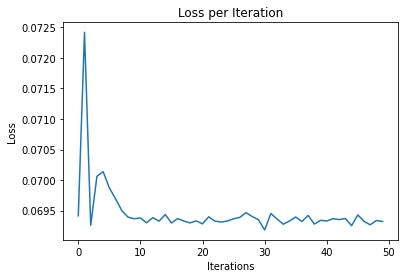

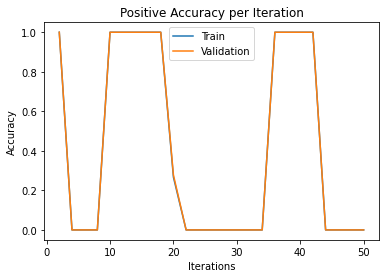

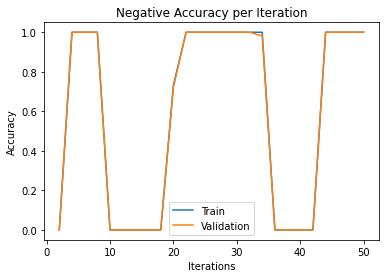

Iter 2. [Val Acc 50%] [Train Acc 50%, Loss 0.696028]
Iter 2. [Val Acc 0%] [Train Acc 0%, Loss 0.696028] (Pos)
Iter 2. [Val Acc 100%] [Train Acc 100%, Loss 0.696028] (Neg)

Iter 4. [Val Acc 52%] [Train Acc 50%, Loss 0.692211]
Iter 4. [Val Acc 48%] [Train Acc 60%, Loss 0.692211] (Pos)
Iter 4. [Val Acc 56%] [Train Acc 40%, Loss 0.692211] (Neg)

Iter 6. [Val Acc 50%] [Train Acc 50%, Loss 0.692335]
Iter 6. [Val Acc 100%] [Train Acc 100%, Loss 0.692335] (Pos)
Iter 6. [Val Acc 0%] [Train Acc 0%, Loss 0.692335] (Neg)

Iter 8. [Val Acc 51%] [Train Acc 53%, Loss 0.696300]
Iter 8. [Val Acc 100%] [Train Acc 100%, Loss 0.696300] (Pos)
Iter 8. [Val Acc 2%] [Train Acc 7%, Loss 0.696300] (Neg)

Iter 10. [Val Acc 50%] [Train Acc 50%, Loss 0.696867]
Iter 10. [Val Acc 0%] [Train Acc 0%, Loss 0.696867] (Pos)
Iter 10. [Val Acc 100%] [Train Acc 100%, Loss 0.696867] (Neg)

Iter 12. [Val Acc 50%] [Train Acc 50%, Loss 0.694489]
Iter 12. [Val Acc 0%] [Train Acc 0%, Loss 0.694489] (Pos)
Iter 12. [Val Acc 100%] [

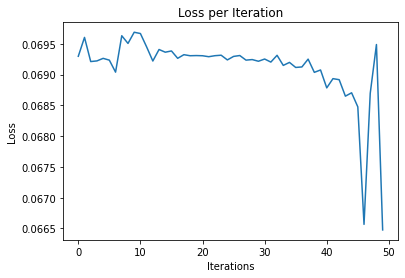

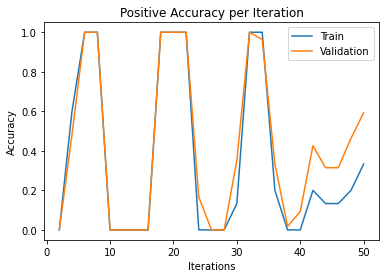

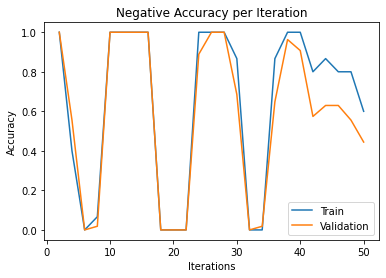

In [41]:
cnn_model = CNN()
cnni = train_model(cnn_model, train_data=train_data[:5], 
                   valid_data=valid_data, batch_size=10, 
                   max_iters=50, max_epoch=50, learning_rate=0.001)
plot_curves(*cnni)

cnnc_model = CNNChannel()
cnnci = train_model(cnnc_model, train_data=train_data[:5], 
                    valid_data=valid_data, batch_size=10, 
                    max_iters=50, max_epoch=50, learning_rate=0.001)
plot_curves(*cnnci)

### Part (c) -- 4 pts

Train your models from Q2(a) and Q2(b). You will want to explore the effects of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and potentially
the kernel size. You do not need to check all values for all hyperparameters. Instead,
get an intuition about what each of the parameters do.

In this section, explain how you tuned your hyperparameters.

In [47]:
cnn_model = CNN()
cnni = train_model(cnn_model, train_data=train_data, 
                   valid_data=valid_data, batch_size=100, 
                   max_iters=200, max_epoch=75, learning_rate=0.001)

cnnc_model = CNNChannel()
cnnci = train_model(cnnc_model, train_data=train_data, 
                    valid_data=valid_data, batch_size=60, 
                    max_iters=200, max_epoch=15, learning_rate=0.001)

# Run 1: Similar hyperparameters as 4b
#   CNN: batch_size = 10, max_iter = 50, max_epoch = 50
#   CNNC: batch_size = 10, max_iter = 50, max_epoch = 50
#   Loss occilates too much so I increased the the batch_size
#   Raised epoch by 10
# Run 2:
#   CNN: batch_size = 20, max_iter = 60, max_epoch = 60
#   CNNChannel: batch_size = 20, max_iter = 60, max_epoch = 60
#   Still similar results so raised batch_size by 10
#   Kept epoch and max_iter same
# Run 3: 
#   CNN: batch_size = 50, max_iter = 60, max_epoch = 60
#   CNNChannel: batch_size = 20, max_iter = 60, max_epoch = 60
#   Increase batch_size drastically 
#   Increase max_iter drastically 
#   Increase epoch drastically
# Run 4: 
#   CNN: batch_size = 100, max_iter = 150, max_epoch = 100
#   CNNChannel: batch_size = 60, max_iter = 150, max_epoch = 100
#   Kept other params
#   Lowered epoch drastically
# Run 5:
#   CNN: batch_size = 100, max_iter = 200, max_epoch = 45
#   CNNChannel: batch_size =60, max_iter = 200, max_epoch = 45
#   Kept other params
#   Increased epoch
# Run 6:
#   CNN: batch_size = 100, max_iter = 200, max_epoch = 75
#   CNNChannel: batch_size = 60, max_iter = 200, max_epoch = 15
#   Best results

Iter 4. [Val Acc 50%] [Train Acc 50%, Loss 0.695002]
Iter 4. [Val Acc 100%] [Train Acc 100%, Loss 0.695002] (Pos)
Iter 4. [Val Acc 0%] [Train Acc 0%, Loss 0.695002] (Neg)

Iter 8. [Val Acc 50%] [Train Acc 50%, Loss 0.693727]
Iter 8. [Val Acc 0%] [Train Acc 0%, Loss 0.693727] (Pos)
Iter 8. [Val Acc 100%] [Train Acc 100%, Loss 0.693727] (Neg)

Iter 12. [Val Acc 50%] [Train Acc 50%, Loss 0.693200]
Iter 12. [Val Acc 100%] [Train Acc 100%, Loss 0.693200] (Pos)
Iter 12. [Val Acc 0%] [Train Acc 0%, Loss 0.693200] (Neg)

Iter 16. [Val Acc 50%] [Train Acc 50%, Loss 0.693406]
Iter 16. [Val Acc 100%] [Train Acc 100%, Loss 0.693406] (Pos)
Iter 16. [Val Acc 0%] [Train Acc 0%, Loss 0.693406] (Neg)

Iter 20. [Val Acc 50%] [Train Acc 50%, Loss 0.693215]
Iter 20. [Val Acc 0%] [Train Acc 0%, Loss 0.693215] (Pos)
Iter 20. [Val Acc 100%] [Train Acc 100%, Loss 0.693215] (Neg)

Iter 24. [Val Acc 50%] [Train Acc 50%, Loss 0.693496]
Iter 24. [Val Acc 0%] [Train Acc 0%, Loss 0.693496] (Pos)
Iter 24. [Val Acc 1

### Part (d) -- 2 pts

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in the next question.

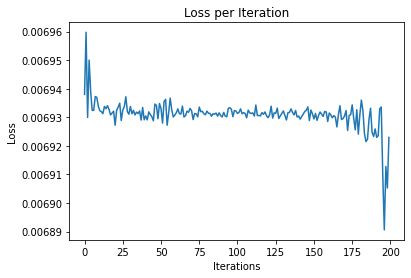

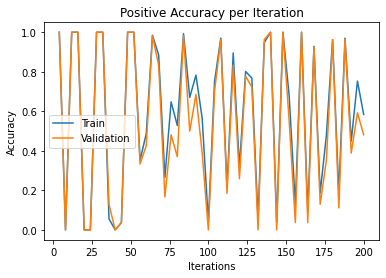

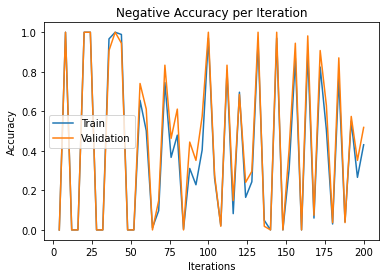

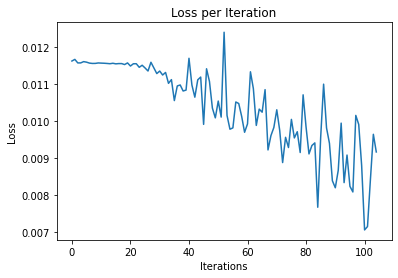

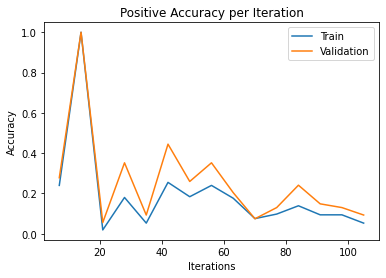

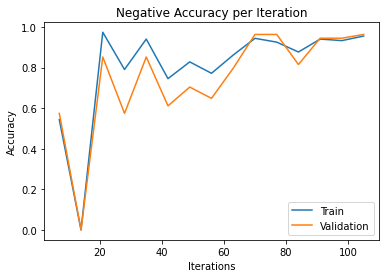

In [48]:
plot_curves(*cnni)
plot_curves(*cnnci)

## Question 5. Test Accuracy

### Part (a) -- 3 pts

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the checkpoint of the model
architecture that produces the best validation accuracy. That is,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [49]:
# We chose the cnn_channel_model because it consistently got better results
test_acc_m = get_accuracy(cnnc_model, test_data_m)
test_acc_w = get_accuracy(cnnc_model, test_data_w)

print("Positive Male Test Accuracy: %.0f%%" % (test_acc_m[0]*100))
print("Positive Female Test Accuracy: %.0f%%" % (test_acc_w[0]*100))
print("Negative Male Test Accuracy: %.0f%%" % (test_acc_m[1]*100))
print("Negative Female Test Accuracy: %.0f%%" % (test_acc_w[1]*100))

Positive Male Test Accuracy: 7%
Positive Female Test Accuracy: 13%
Negative Male Test Accuracy: 93%
Negative Female Test Accuracy: 87%


### Part (b) -- 1 pts

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


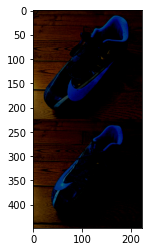

In [ ]:
mshoe = generate_same_pair(test_data_m)
cnnc_model.eval()
xs = torch.Tensor(mshoe).transpose(1, 3).transpose(2, 3)
zs = cnnc_model(xs)
pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
pred = pred.detach().numpy()
shoe = mshoe[np.where(pred==0)[0][0]]
plt.figure()
plt.imshow(shoe)

### Part (c) -- 1 pts

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


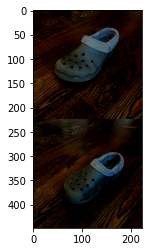

In [ ]:
wshoe = generate_same_pair(test_data_w)
cnnc_model.eval()
xs = torch.Tensor(wshoe).transpose(1, 3).transpose(2, 3)
zs = cnnc_model(xs)
pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
pred = pred.detach().numpy()
shoe = wshoe[np.where(pred==0)[0][0]]
plt.figure()
plt.imshow(shoe)

## Question 6. Graph Neural Networks

In this question, we will introduce a relatively new type of neural network
that generalizes convolutions, namely Graph Neural Networks (GNNs).

Recall that a *graph* is a pair $G = (V, E)$ consisting of a set of *vertices*
(also called *nodes*) $V$ and a set of *edges* $E$.
Each edge is a pair of vertices, denoting a connection between them in the graph.
For example, the graph below is represented by the sets
$V = \{ v_1, v_2, v_3, v_4 \}$ and $E = \{ (v_1, v_2), (v_2, v_3), (v_2, v_4), (v_3, v_4) \}$.
We will only consider undirected graphs for this question,
so the ordering of the nodes in each edge is not important.

![](CSC413_ExampleGraph.png){ width=200px }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)


Many different types of structured data can be represented by graphs.
In particular, an image can be represented by a grid-structured graph!
Each node represents a pixel, and edges represent adjacency between pixels in space.

Graph Neural Networks (GNNs) generalize convolutions for arbitrary graph-structured data.
Each node is associated with a vector representation (like the RGB representation of a pixel).
A "layer" in a GNN updates the representation of each node $v$ by taking a linear
combination of the representations of its neighbours $u \in N(v)$
(just like how a 3x3 convolution updates a pixel's representation by taking
a linear combinations of the pixel's 8 direct neighbours, plus the pixel itself!).

If we denote the representation at node $v$ after the $\ell^{th}$ layer by
$\mathbf{h}_v^{(l)}$, then its representation after a GNN update is:

$$\mathbf{h}_v^{(l+1)} = f\left( \sum_{u \in N(v) \cup \{ v \}} \mathbf{W}^{(l+1)} \mathbf{h}^{(l)}_u \right)$$

Here, $f$ is a nonlinearity such as ReLU, and $\mathbf{W}^{(l+1)}$ are the
parameters of the $(l+1)^{th}$ layer of the GNN.

After $k$ GNN layers, each node's representation is affected by other nodes
within a $k$-hop radius (this is similar to the receptive field analysis
from earlier).
Deeper models are able to extract higher-level representations for each node by
aggregating information from larger neighbourhoods.

There are two main types of prediction tasks we may want to perform on graphs:
*node-level* (is this pixel a part of a cat?) and *graph-level* (is this molecule,
represented by this entire graph, be useful for treating a disease?).
We can obtain a representation of an entire graph by 
aggregating the final representations of each node in the graph.

For the rest of this question, we'll assume that we want to make a prediction about
the entire graph. Our GNN will compute a single scalar for the graph:

$$
y = \sigma \left( \mathbf{q}^\top \left( \sum_{v \in V} \mathbf{h}_v \right) \right)
$$
where $\mathbf{q}$ is a vector of the same dimensionality as $\mathbf{h}$ (so that the inner product is a scalar) and the activation $\sigma$ is the logistic sigmoid.


### Part (a) -- 2 pts

In this question, we will be applying graph convolutions by hand in the simple graph
from above. The figure below shows the initial vector representation of each vertex.
(Think of these vectors $h_k^{0}$ as similar to the vector of RGB values at each pixel
in the earlier parts of this assignment.)

![](CSC413_ExerciseGraph.png){ width=300px }

(Image might not show up in the .ipynb file. If so, please check the
PDF version of the handout.)

Suppose that the parameters of the GNN are as follows:
$$
\mathbf{W} =
\begin{bmatrix}
1 & 2 \\
0 & 1
\end{bmatrix}
% \qquad \qquad
% V =
% \begin{bmatrix}
% 1 & 1 \\
% 1 & 1
% \end{bmatrix}
\qquad \qquad
\mathbf{q} = 
\begin{bmatrix}
1 & 1
\end{bmatrix}
$$

Compute 1 convolutional update step in this graph. 
In other words, find the updated representations for each node after
1 propagation step and report the values $\mathbf{h}^{(1)}_1$,
$\mathbf{h}^{(1)}_2$, $\mathbf{h}^{(1)}_3$, $\mathbf{h}^{(1)}_4$.

![picture](https://drive.google.com/uc?export=view&id=1nxW0cpShSCXCdO3bjAaXSFj7Gve2ux17)

### Part (b) -- 2 pts

Compute the graph-level output based on the representations you computed in part 1.

![picture](https://drive.google.com/uc?export=view&id=1GBJRFDf7y0DJTWI8DxeRRQpraARPXgBG)

### Part (c) -- 4 pts

Assume that the target for the graph-level output is $0$,
and that we're using cross-entropy loss. Use backpropagation to compute the gradient of the parameters of the GNN.

![picture](https://drive.google.com/uc?export=view&id=1cA2-Tq3mjpxckjB_Hc2nKSRiadJoIam2)

![picture](https://drive.google.com/uc?export=view&id=1C-8q2UXdGuJEJw83FVjWbIny9G8-g0sf)

![picture](https://drive.google.com/uc?export=view&id=1QUG_xLgfnK9lpVFXjfjgzsGuzLV8JnxG)

## Question 7. Work Allocation -- 2 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Wafiqah and David read the assignment on our own time and discussed it on 
# Feb 15th, 3pm-5pm. Wafiqah worked on the assignment Feb 18th, 7pm-10pm Feb 18th, 1pm - 4pm
# David worked on the assignment Feb 18th, 11am - 5pm, Jan 20th, 3pm - 6pm.
# We had a meeting on Feb 22th, Feb 25th, Feb 27th, Feb 2nd, Feb 4th, Feb 5th
# all around 6pm - 11pm.

# David worked on Q1 and Wafiqah reviewed the code.
# David worked out the math for Q2 explained it to Wafiqah. David worked on q3 and explained it to Wafiqah
# We worked on Q4, Q5, and Q6 together while screensharing. 